In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import zscore


In [2]:
# Load CSV data
input_path = r"D:\Workspace\weight_logger\source_file"
output_path = r"D:\Workspace\weight_logger\output_file"
input_file_path = f"{input_path}\Weight_Logger.csv"  # Update with actual file path

In [3]:
df = pd.read_csv(input_file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                38 non-null     object 
 1   Weight              38 non-null     float64
 2   Calories(Resting)   38 non-null     int64  
 3   Calories(Activity)  38 non-null     int64  
 4   Daily Steps         38 non-null     int64  
 5   Daily Kilometers    38 non-null     float64
 6   Sleep Duration      38 non-null     object 
 7   Sleep Score         38 non-null     int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 2.5+ KB


In [4]:
# Ensure required columns exist
required_columns = {"Date","Weight", "Calories(Activity)", "Calories(Resting)", "Daily Steps", "Daily Kilometers", "Sleep Score", "Sleep Duration"}
missing_columns = required_columns - set(df.columns)
if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")


In [5]:
# Convert date column to datetime
df["Date"] = pd.to_datetime(df["Date"], errors='coerce')
df = df.dropna(subset=["Date"])  # Remove rows where date conversion failed

C:\Users\shahi\AppData\Local\Temp\ipykernel_25480\1055560127.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Date"] = pd.to_datetime(df["Date"], errors='coerce')


In [6]:
# Take height input from user
while True:
    try:
        height = float(input("Enter your height in meters: "))
        if height <= 0:
            raise ValueError("Height must be a positive number.")
        break
    except ValueError:
        print("Invalid input. Please enter a valid height in meters.")

print("Entered Height in meters:", height/100)

Entered Height in meters: 1.83


In [7]:
# Calculate BMI for each weight entry
df["BMI"] = df["Weight"] / ((height/100) ** 2)

In [8]:
# Categorize BMI
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 24.9:
        return "Normal weight"
    elif 25.0 <= bmi < 29.9:
        return "Overweight"
    else:
        return "Obese"

df["BMI Category"] = df["BMI"].apply(categorize_bmi)

In [9]:
# Calculate Net Calories
df["Net Calories"] = df["Calories(Activity)"].fillna(0) + df["Calories(Resting)"].fillna(0)

In [10]:
# Step and Distance Efficiency
df["Calories per Step"] = df["Calories(Activity)"] / df["Daily Steps"]
df["Calories per KM"] = df["Calories(Activity)"] / df["Daily Kilometers"]

In [11]:
# Activity Level Classification
def classify_activity(steps):
    if steps < 5000:
        return "Sedentary"
    elif steps < 7500:
        return "Lightly Active"
    elif steps < 10000:
        return "Moderately Active"
    else:
        return "Very Active"
df["Activity Level"] = df["Daily Steps"].apply(classify_activity)

In [12]:
# Weight Trends Over Time if date column exists
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(by="Date")
    df["Weight Change Rate"] = df["Weight"].diff() / df["Date"].diff().dt.days
    df["7-Day Moving Avg"] = df["Weight"].rolling(window=7).mean()
    df["30-Day Moving Avg"] = df["Weight"].rolling(window=30).mean()

In [13]:
# Weekly and Monthly Averages
df["week"] = df["Date"].dt.isocalendar().week
df["month"] = df["Date"].dt.month

# Convert necessary columns to numeric, forcing errors='coerce' to handle non-numeric values
cols_to_convert = ["Weight", "Daily Steps", "Calories(Activity)", "Sleep Duration"]
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Now apply groupby and mean
weekly_avg = df.groupby("week")[cols_to_convert].mean()
monthly_avg = df.groupby("month")[cols_to_convert].mean()



In [14]:
# Correlation Analysis for Sleep and Weight
df["Sleep-Weight Corr"] = df["Sleep Duration"].rolling(window=7).corr(df["Weight"])

In [15]:
# Predictive Analysis - Linear Regression
if "Date" in df.columns:
    df.dropna(subset=["Weight", "Date"], inplace=True)  # Drop NaN only from relevant columns
    if not df.empty:
        df["days_since_start"] = (df["Date"] - df["Date"].min()).dt.days
        X = df[["days_since_start"]]  # Use days since start as independent variable
        y = df["Weight"]
        if len(X) > 1:  # Ensure there are enough samples
            model = LinearRegression()
            model.fit(X, y)
            future_days = np.array(range(df["days_since_start"].max() + 1, df["days_since_start"].max() + 31)).reshape(-1, 1)
            future_weights = model.predict(future_days)
            df_future = pd.DataFrame({
                "Date": pd.date_range(start=df["Date"].iloc[-1] + pd.Timedelta(days=1), periods=30, freq='D'),
                "Predicted Weight": future_weights
            })
        else:
            print("Not enough data points for linear regression.")
    else:
        print("No data available after dropping NaN values.")


C:\Users\shahi\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [16]:
# Correlation matrix
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr(method='pearson')  # Using Pearson correlation method
print("\nCorrelation Matrix:\n", correlation_matrix["Weight"].sort_values(ascending=False))


Correlation Matrix:
 BMI                   1.000000
Weight                1.000000
7-Day Moving Avg      0.989045
30-Day Moving Avg     0.774055
Calories per Step     0.204849
Calories per KM       0.117227
Weight Change Rate    0.006484
Sleep Score          -0.443851
Calories(Activity)   -0.544427
Daily Kilometers     -0.591165
Daily Steps          -0.604632
Calories(Resting)    -0.638356
Net Calories         -0.644180
month                -0.853548
week                 -0.966039
days_since_start     -0.975838
Sleep Duration             NaN
Sleep-Weight Corr          NaN
Name: Weight, dtype: float64


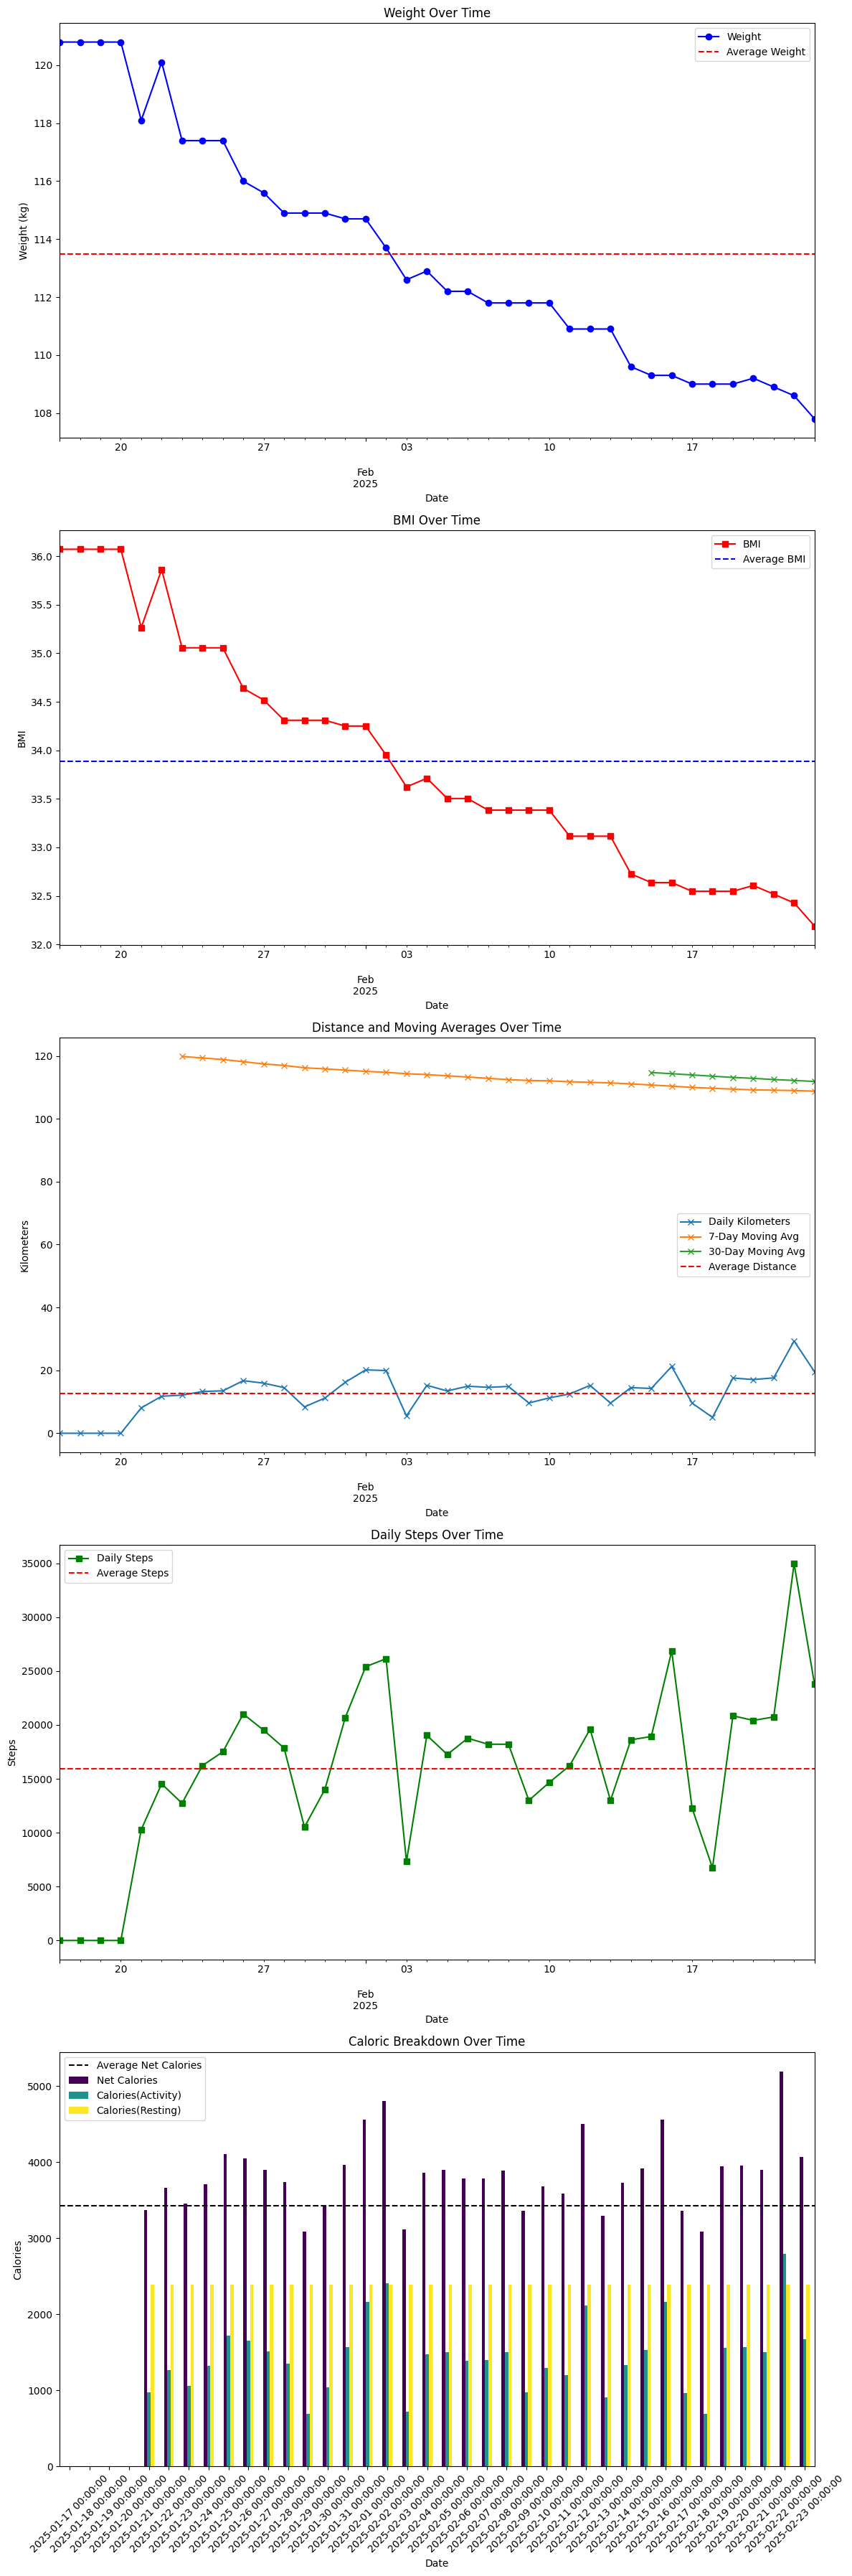

In [17]:
# Visualization - Time Series Plots
fig, axes = plt.subplots(5, 1, figsize=(12, 36))

# Subplot 1: Weight Over Time
df.plot(x="Date", y="Weight", ax=axes[0], marker='o', color='blue')
axes[0].axhline(df["Weight"].mean(), color='red', linestyle='dashed', label='Average Weight')
axes[0].set_title("Weight Over Time")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Weight (kg)")
axes[0].legend()

# Subplot 2: BMI Over Time
df.plot(x="Date", y="BMI", ax=axes[1], marker='s', color='red')
axes[1].axhline(df["BMI"].mean(), color='blue', linestyle='dashed', label='Average BMI')
axes[1].set_title("BMI Over Time")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("BMI")
axes[1].legend()

# Subplot 3: Distance and Moving Averages
df.plot(x="Date", y=["Daily Kilometers", "7-Day Moving Avg", "30-Day Moving Avg"], ax=axes[2], marker='x')
axes[2].axhline(df["Daily Kilometers"].mean(), color='red', linestyle='dashed', label='Average Distance')
axes[2].set_title("Distance and Moving Averages Over Time")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Kilometers")
axes[2].legend()

# Subplot 4: Daily Steps
df.plot(x="Date", y="Daily Steps", ax=axes[3], marker='s', color='green')
axes[3].axhline(df["Daily Steps"].mean(), color='red', linestyle='dashed', label='Average Steps')
axes[3].set_title("Daily Steps Over Time")
axes[3].set_xlabel("Date")
axes[3].set_ylabel("Steps")
axes[3].legend()

# Subplot 5: Net Calories, Activity, and Resting Calories as Bar Plot
df.plot(x="Date", y=["Net Calories", "Calories(Activity)", "Calories(Resting)"], kind="bar", ax=axes[4], colormap='viridis')
axes[4].axhline(df["Net Calories"].mean(), color='black', linestyle='dashed', label='Average Net Calories')
axes[4].set_title("Caloric Breakdown Over Time")
axes[4].set_xlabel("Date")
axes[4].set_ylabel("Calories")
axes[4].legend()


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

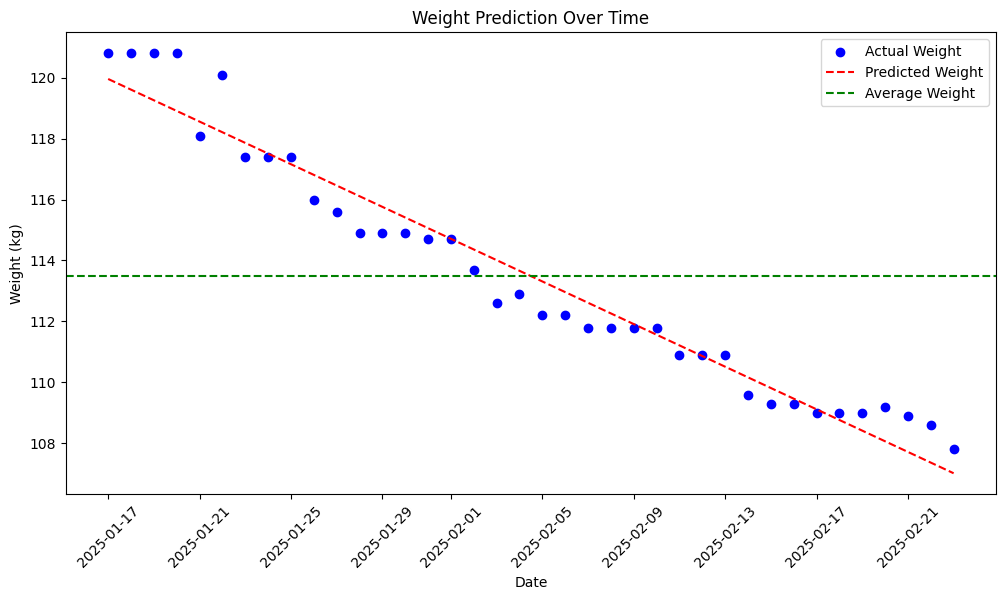

In [18]:
# Predictive Analysis - Linear Regression
X = np.arange(len(df)).reshape(-1, 1)
y = df["Weight"].values

if len(X) > 1:
    model = LinearRegression()
    model.fit(X, y)
    df["Predicted Weight"] = model.predict(X)

    plt.figure(figsize=(12, 6))
    plt.scatter(df["Date"], df["Weight"], color='blue', label='Actual Weight')
    plt.plot(df["Date"], df["Predicted Weight"], color='red', linestyle='dashed', label='Predicted Weight')
    plt.axhline(df["Weight"].mean(), color='green', linestyle='dashed', label='Average Weight')
    plt.title("Weight Prediction Over Time")
    plt.xlabel("Date")
    plt.ylabel("Weight (kg)")
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [19]:
# 1. Weight Trend Analysis using Polynomial Regression
X = np.arange(len(df)).reshape(-1, 1)
y = df["Weight"].values
poly_model = LinearRegression()
poly_model.fit(X, y)
df["Weight Trend"] = poly_model.predict(X)

In [20]:
# 2. Sleep vs. Caloric Burn Analysis
sleep_cal_corr = df["Sleep Duration"].corr(df["Net Calories"])
print(f"Correlation between sleep duration and calorie burn: {sleep_cal_corr}")

Correlation between sleep duration and calorie burn: nan


C:\Users\shahi\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\shahi\AppData\Roaming\Python\Python311\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [21]:
# 3. Step Count Clustering
scaler = StandardScaler()
df["scaled_steps"] = scaler.fit_transform(df[["Daily Steps"]])
kmeans = KMeans(n_clusters=3, random_state=42)
df["Activity Cluster"] = kmeans.fit_predict(df[["scaled_steps"]])

In [22]:
# 4. Ideal Weight Comparison
ideal_weight = 22 * (height ** 2)
df["Weight Deviation"] = df["Weight"] - ideal_weight

In [23]:
# 5. Activity Impact on Weight
activity_model = LinearRegression()
X_activity = df[["Daily Steps", "Net Calories"]]
y_weight = df["Weight"]
activity_model.fit(X_activity, y_weight)
print(f"Activity impact coefficients: {activity_model.coef_}")

Activity impact coefficients: [-6.37384556e-05 -1.66263352e-03]


In [24]:
# 6. Sleep Quality Impact (assuming sleep efficiency available)
if "Sleep Efficiency" in df.columns:
    sleep_eff_corr = df["Sleep Efficiency"].corr(df["weight"])
    print(f"Correlation between sleep efficiency and weight: {sleep_eff_corr}")

In [25]:
# 7. Metabolic Rate Estimation (BMR using Mifflin-St Jeor)
age = 30  # Assuming an age input
bmr = 10 * df["Weight"] + 6.25 * (height * 100) - 5 * age + 5  # Assuming male, subtract 161 for female
print(f"Estimated BMR: {bmr.mean()}")

Estimated BMR: 115364.86842105263


In [26]:
# 8. Anomaly Detection in Weight Changes
df["Weight Z-Score"] = zscore(df["Weight"])
df["Anomaly"] = df["Weight Z-Score"].apply(lambda x: "Yes" if abs(x) > 2 else "No")

In [27]:
# Display basic statistics with better formatting
print("\n📊 **Statistics** 📊\n")
print(df.describe().round(2).to_string())  # Rounds values to 2 decimal places and prints in table format

stats_df = df.describe().round(2)  # Round to 2 decimal places

# Define the output file path
output_file = "statistical_output.xlsx"
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Define the full output file path
output_file = os.path.join(output_path, "statistics_output.xlsx")

# Save to Excel
stats_df.to_excel(output_file, sheet_name="Statistics")

print(f"✅ Statistics exported successfully to: {output_file}")


📊 **Statistics** 📊

                      Date  Weight  Calories(Resting)  Calories(Activity)  Daily Steps  Daily Kilometers  Sleep Duration  Sleep Score    BMI  Net Calories  Calories per Step  Calories per KM  Weight Change Rate  7-Day Moving Avg  30-Day Moving Avg  week  month  Sleep-Weight Corr  days_since_start  Predicted Weight  Weight Trend  scaled_steps  Activity Cluster  Weight Deviation  Weight Z-Score
count                   38   38.00              38.00               38.00        38.00             38.00             5.0        38.00  38.00         38.00              34.00            34.00               37.00             32.00               9.00  38.0  38.00                0.0             38.00             38.00         38.00         38.00             38.00             38.00           38.00
mean   2025-02-04 12:00:00  113.49            2138.42             1291.16     15946.92             12.75             0.0        70.34  33.89       3429.58               0.08           102

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                38 non-null     datetime64[ns]
 1   Weight              38 non-null     float64       
 2   Calories(Resting)   38 non-null     int64         
 3   Calories(Activity)  38 non-null     int64         
 4   Daily Steps         38 non-null     int64         
 5   Daily Kilometers    38 non-null     float64       
 6   Sleep Duration      5 non-null      float64       
 7   Sleep Score         38 non-null     int64         
 8   BMI                 38 non-null     float64       
 9   BMI Category        38 non-null     object        
 10  Net Calories        38 non-null     int64         
 11  Calories per Step   34 non-null     float64       
 12  Calories per KM     34 non-null     float64       
 13  Activity Level      38 non-null     object        
 

In [29]:
# Write BMI, BMI Category, and Net Calories back to CSV
if not os.path.exists(output_path):
    os.makedirs(output_path)
# Define the full file path
output_file_path = os.path.join(output_path, "updated_Weight_logger.csv")
df.to_csv(output_file_path, index=False, columns=["Date", "Weight", "Calories(Resting)", "Calories(Activity)", "Daily Steps", "Daily Kilometers",
                                                  "Sleep Duration", "Sleep Score", "BMI", "BMI Category", "Net Calories", "Calories per Step",
                                                  "Calories per KM", "Activity Level", "Weight Change Rate", "7-Day Moving Avg", "30-Day Moving Avg",
                                                  "week", "month", "Sleep-Weight Corr", "days_since_start", "Predicted Weight", "Weight Trend",
                                                  "scaled_steps", "Activity Cluster", "Weight Deviation", "Weight Z-Score", "Anomaly"])
print(f"File saved successfully at: {output_file_path}")

File saved successfully at: D:\Workspace\weight_logger\output_file\updated_Weight_logger.csv
